In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pickle
with open('/content/drive/MyDrive/학교/스마트교차로/lstm_val_X.pkl', 'rb') as f:
    lstm_val_X=pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/lstm_val_y.pkl', 'rb') as f:
    lstm_val_y=pickle.load(f)

In [5]:
lstm_val_X = np.array(lstm_val_X[:,:,:17])

In [6]:
from keras.models import load_model
dnn_model = load_model('/content/drive/MyDrive/학교/스마트교차로/dnn_model(날씨 제거).h5')
lstm_model = load_model('/content/drive/MyDrive/학교/스마트교차로/lstm_model(날씨 제거).h5')

# 전체 프레임워크

In [17]:
class Signal_Framework:
  def __init__(self, lstm_model, dnn_model):
    # 최소녹색시간과 최대녹색시간 (-4는 주황불)
    self.min_signal_times = np.array([10, 31, 15, 11, 8, 15])
    self.max_signal_times = np.array([45-4, 55-4, 45-4, 40-4, 35-4, 40-4]) # 41, 51, 41, 36, 31,36

    self.taffic = None
    self.holiday = None

    self.lstm_model = lstm_model
    self.dnn_model = dnn_model

    self.lstm_input = None
    self.lstm_output = None

    self.best_solution = None
    self.best_fitness_per_generation = []


  def dnn_predict_data(self, signal_values, lstm_output):
      """신호 주기에 따라 딥러닝 모델의 입력 데이터를 준비하는 함수"""
      input_data = pd.DataFrame(self.lstm_input)
      holiday_data = pd.DataFrame(input_data.iloc[-1][16:17]).T.reset_index(drop=True)
      # 신호 주기 데이터를 DataFrame으로 변환
      signal = pd.DataFrame([signal_values])
      # 데이터 결합 및 복제
      predict_data = pd.concat([lstm_output, holiday_data, signal], axis=1)
      predict_data = pd.concat([predict_data] * 6, ignore_index=True)

      # 방향 열 추가
      predict_data['방향'] = list(range(6))

      return predict_data

  def prepare_predict_data(self, signal_values):
      """dnn입력 데이터 생성 함수"""
      dnn_predict_data = self.dnn_predict_data(signal_values, self.lstm_output)
      return dnn_predict_data

  def evaluate_population(self, population):
      """집단 평가 함수"""
      # 모든 개체에 대한 DNN 입력 데이터 준비
      all_prepared_data = []
      for individual in population:
          if np.sum(individual) <= 200: # 최대 신호 주기 시간 (초)
              prepared_data = self.prepare_predict_data(individual)
              all_prepared_data.append(prepared_data)
          else:
              all_prepared_data.append(None)

      # 모든 개체의 데이터를 하나의 큰 데이터프레임으로 결합
      all_prepared_data_combined = pd.concat([data for data in all_prepared_data if data is not None], ignore_index=True)

      # 한 번에 모든 데이터에 대한 DNN 예측 수행
      all_predicted_speeds = self.dnn_model.predict(all_prepared_data_combined, verbose=0)

      # 각 개체에 대한 평균 속도 계산
      average_speeds = []
      start_idx = 0
      for prepared_data in all_prepared_data:
          if prepared_data is not None:
              end_idx = start_idx + len(prepared_data)
              predicted_speeds = all_predicted_speeds[start_idx:end_idx]
              weight = np.array([np.sum(prepared_data.iloc[0,0:2]), np.sum(prepared_data.iloc[0,2:5]), np.sum(prepared_data.iloc[0,5:8]), np.sum(prepared_data.iloc[0,8:11]), np.sum(prepared_data.iloc[0,11:13]), np.sum(prepared_data.iloc[0,13:16])])
              average_speeds.append(np.sum(predicted_speeds * weight) / np.sum(prepared_data.iloc[0, 0:16]) / 6)  # 속도 평균 계산
              start_idx = end_idx
          else:
              average_speeds.append(0)  # 합계가 200 초가 넘으면 낮은 평가

      return np.array(average_speeds)

  def select_parents(self, population, fitness, num_parents):
      """부모 선택 함수"""
      parents = np.empty((num_parents, population.shape[1]), dtype=np.int32)
      for parent_num in range(num_parents):
          max_fitness_idx = np.where(fitness == np.max(fitness))[0][0]
          parents[parent_num, :] = population[max_fitness_idx, :]
          fitness[max_fitness_idx] = -9999999999
      return parents

  def crossover(self, parents, offspring_size):
      """교차(교배) 함수"""
      offspring = np.empty(offspring_size, dtype=np.int32)
      crossover_point = np.uint8(offspring_size[1]/2)
      for k in range(offspring_size[0]):
          parent1_idx = k % parents.shape[0]
          parent2_idx = (k + 1) % parents.shape[0]
          offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
          offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
      return offspring

  def mutate(self, offspring_crossover, min_values, max_values, mutation_rate):
      """변이 함수"""
      for idx in range(offspring_crossover.shape[0]):
          if np.random.rand() < mutation_rate: # 변이 확률
              random_index = np.random.randint(0, offspring_crossover.shape[1], size=1)
              random_value = np.random.randint(-5, 6)  # 정수 변이
              offspring_crossover[idx, random_index] = np.clip(offspring_crossover[idx, random_index] + random_value, min_values[random_index], max_values[random_index])
      return offspring_crossover


  def optimize_signal_times(self, lstm_input, population_size=100, num_generations=200, num_parents_mating=10, mutation_rate=0.3):
      """신호 주기 최적화 함수
         집단 개수: 100
         세대 수: 200
         집단 개수 중 상위 n개를 남길지, 나머지 (집단 개수-n)은 상위 n개를 교배시키고 변이하여 다시 생성: 10
         변이 확률: 0.3 (30%)
      """
      # lstm 예측
      self.lstm_input = lstm_input
      self.lstm_output = pd.DataFrame(self.lstm_model.predict(self.lstm_input.reshape(1,24,17), verbose=0)).astype(int)

      # 유전 알고리즘
      self.best_fitness_per_generation = []  # 각 세대의 최고 적합도 리스트 초기화
      population = self.create_initial_population(population_size, self.min_signal_times, self.max_signal_times)
      for generation in trange(num_generations, leave = False):
          fitness = self.evaluate_population(population)
          current_best_fitness = np.max(fitness)
          self.best_fitness_per_generation.append(current_best_fitness)

          # 적합도 개선율 확인 및 알고리즘 중단 조건
          if generation >= 100: # 최소 세대 진행 수
              # 최근 10세대의 적합도 개선율 계산
              exist_best_fitness = max(self.best_fitness_per_generation[:-20])
              recent_best_fitness = max(self.best_fitness_per_generation[-20:])
              fitness_improvement_rate = abs(recent_best_fitness - exist_best_fitness) / exist_best_fitness
              if fitness_improvement_rate <= 0.000005:  # 0.0005%보다 작은 개선율
                  print(f"Generation {generation}: Improvement rate {fitness_improvement_rate} is below threshold. Stopping optimization.")
                  break


          parents = self.select_parents(population, fitness, num_parents_mating)
          offspring_crossover = self.crossover(parents, offspring_size=(population_size - parents.shape[0], population.shape[1]))
          offspring_mutation = self.mutate(offspring_crossover, self.min_signal_times, self.max_signal_times, mutation_rate)
          population[0:parents.shape[0], :] = parents # 상위 num_parents_mating개 만큼 살림
          population[parents.shape[0]:, :] = offspring_mutation # 하위 (population_size - num_parents_mating)개는 교배 및 변이된걸로 교체
          population = self.replace_duplicates_with_new_individuals(population) # 중복 제거 및 다시 랜덤수 생성

      final_fitness = self.evaluate_population(population)
      self.best_solution = population[np.argmax(final_fitness)]
      best_solution_speed = np.max(final_fitness)
      return self.best_solution, best_solution_speed

  def create_initial_population(self, population_size, min_values, max_values):
      """초기 집단 생성 함수"""
      population = []
      for _ in range(population_size):
          individual = np.random.randint(min_values, max_values + 1, size=len(min_values))
          population.append(individual)
      return np.array(population)

  def replace_duplicates_with_new_individuals(self, population):
      # 중복 개체 찾기 및 대체
      unique_population = np.unique(population, axis=0)
      if len(unique_population) < len(population):
          # 중복이 존재하는 경우
          new_individuals_count = len(population) - len(unique_population)
          for _ in range(new_individuals_count):
              # 새 개체 생성
              new_individual = np.random.randint(self.min_signal_times, self.max_signal_times + 1, size=len(self.min_signal_times))
              # 중복 검사
              while any(np.array_equal(new_individual, individual) for individual in unique_population):
                  new_individual = np.random.randint(self.min_signal_times, self.max_signal_times + 1, size=len(self.min_signal_times))
              # 중복이 아닌 새 개체 추가
              unique_population = np.append(unique_population, [new_individual], axis=0)

      # 업데이트된 population 반환
      return unique_population

  def predictions_after(self):
      return self.dnn_model.predict(self.prepare_predict_data(self.best_solution), verbose=0)

  def plot_fitness_trend(self):
      #세대별 최고 적합도 추세 그래프 생성
      plt.plot(self.best_fitness_per_generation)
      plt.title('Generation vs Best Fitness Trend')
      plt.xlabel('Generation')
      plt.ylabel('Best Fitness')
      plt.show()

### 입력

In [15]:
# 10월 16일~31일(필요시 사용)
lstm_input = lstm_val_X[34]

In [19]:
# 이 형태를 맞춰 입력 데이터 생성
(lstm_input.shape, type(lstm_input))

((24, 17), numpy.ndarray)

### 프레임워크 사용

In [13]:
framework = Signal_Framework(lstm_model, dnn_model) # 클래스 생성 lstm, dnn 모델 필요

def lstm_input_to_result(traffic):
    best_signal_times, best_speed = framework.optimize_signal_times(traffic) # 신호, 속도 출력
    individual_speed = framework.predictions_after() # 개별 진입로 속도
    individual_traffic = framework.lstm_output # 개별 교통량
    return (best_signal_times, best_speed, individual_speed, individual_traffic)

In [16]:
result = lstm_input_to_result(lstm_input)

  0%|          | 0/10 [00:00<?, ?it/s]

(array([41, 51, 15, 14, 31, 35]),
 39.215182622273765,
 array([[39.683624],
        [42.59164 ],
        [45.510845],
        [35.573795],
        [29.025097],
        [42.906075]], dtype=float32),
    0    1    2    3   4   5    6   7    8   9   10   11  12  13   14  15
 0  91  133  175  104  69  49  152  28  105  64  11  139  38  93  120  37)

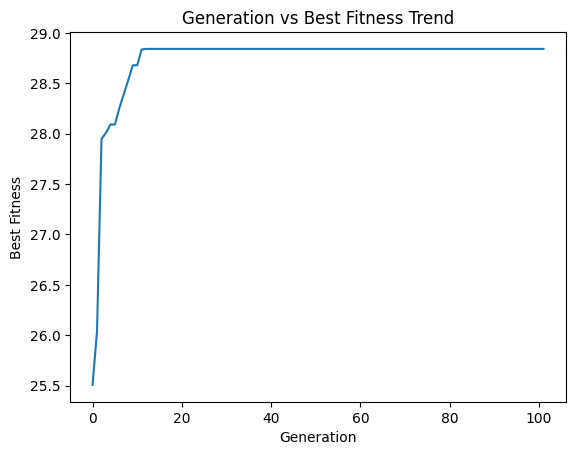

In [ ]:
# 세대별 최고 적합도 추세 그래프
framework.plot_fitness_trend()

### 평균 속도 구하는 법
예시)  
1 | 100 | 28.060284  
2 | 2000 | 30.958614  
3 | 30 | 35.443607  
4 | 50 | 31.406345  
5 | 20 | 31.406345  
6 | 10 | 31.406345  

평균 속도 = (100* 28.060284 + 2000 * 30.958614 ...) / (100 + 2000..)

In [ ]:
# 출력값 확인
# result 기준.  result[0] : 최적 신호, result[1] : 전체 평균 속도, result[2] : 개별 진입로 속도, result[3] : 개별 진입로 교통량,
result

In [ ]:
# 출력값 저장
with open("/content/drive/MyDrive/학교/스마트교차로/result.pkl","wb") as fw:
  pickle.dump(result, fw)

### 순서 사진

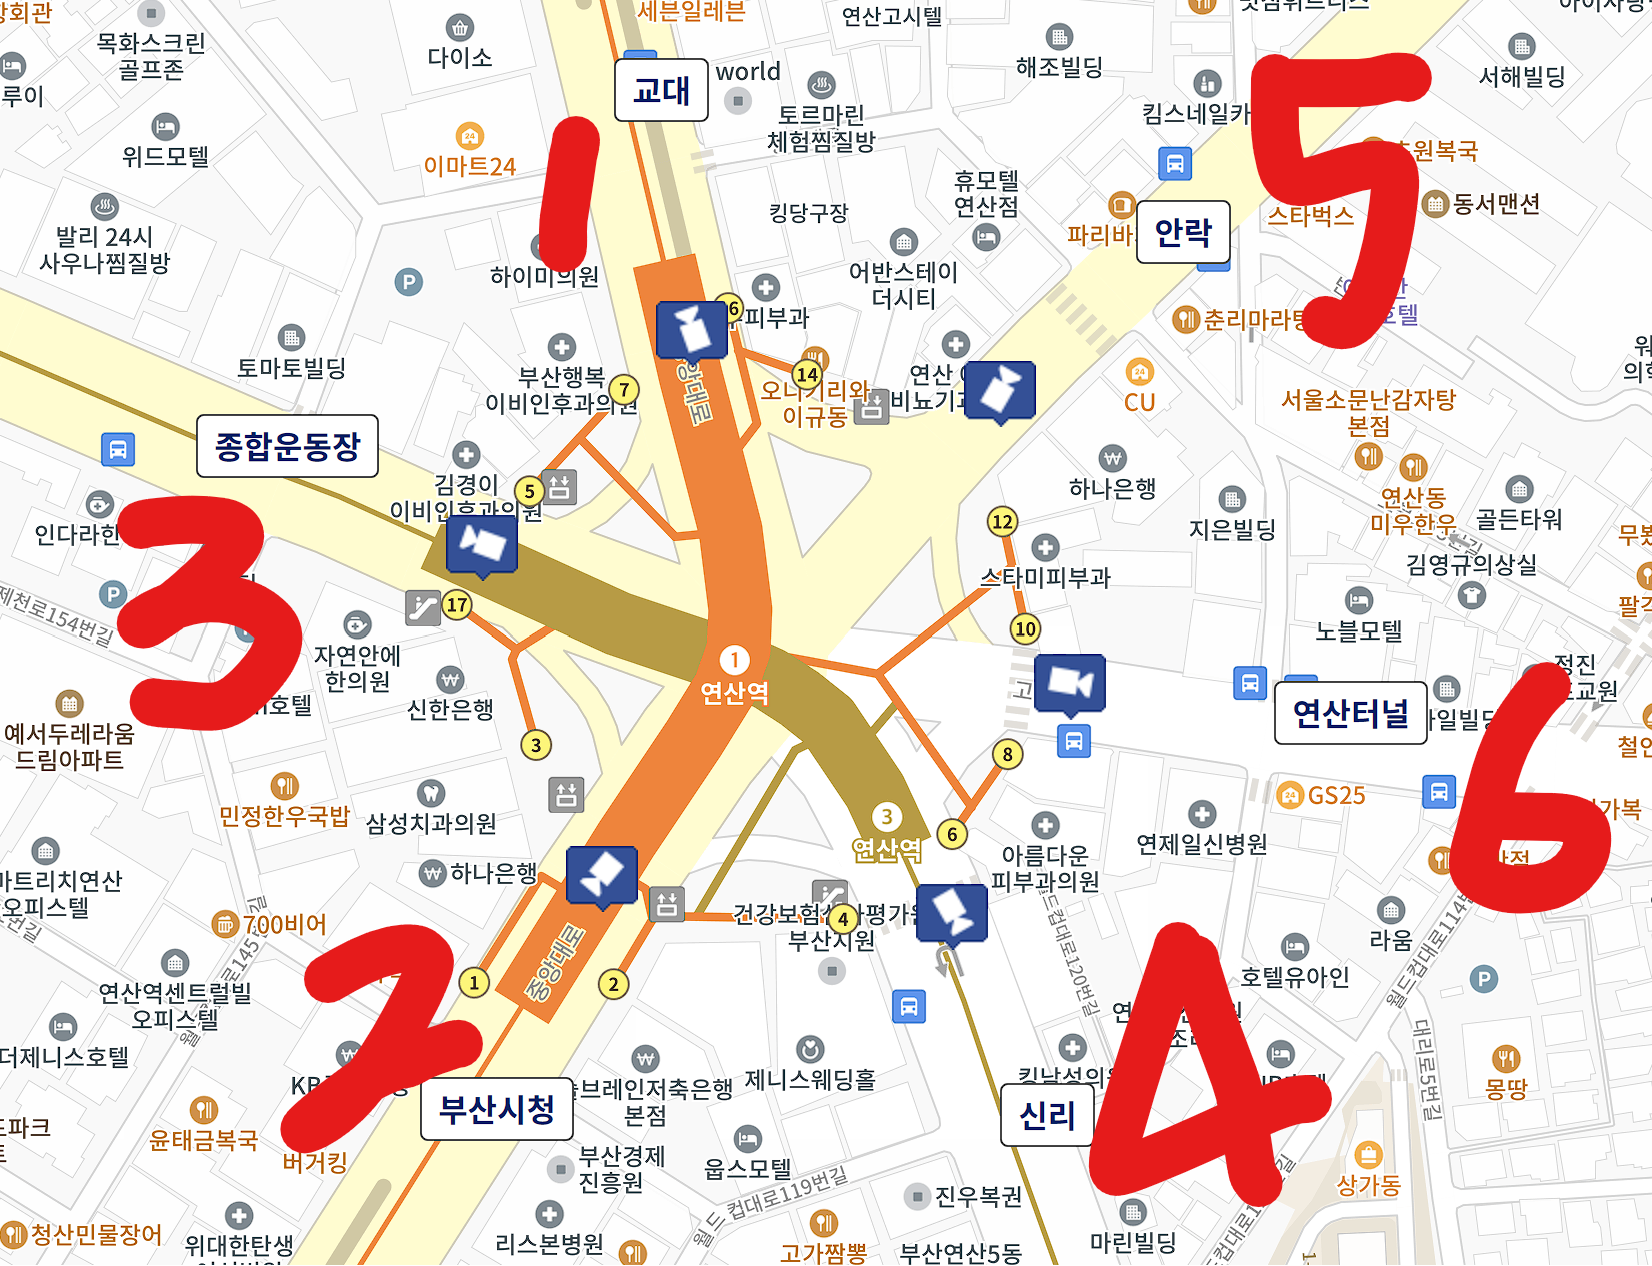

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/학교/스마트교차로/진입로 순번.png", width=500)